In [114]:
import cv2 as cv
import importlib
import io
from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps, ImageChops, ImageDraw
from scipy.stats import norm
import seaborn as sns
import SimpleITK as sitk
from sklearn.mixture import GaussianMixture
from skimage.color import rgb2hed
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_holes, remove_small_objects
import staintools
from staintools import stain_normalizer, LuminosityStandardizer
from staintools.preprocessing.input_validation import is_uint8_image
import sys

In [93]:
%matplotlib notebook

In [3]:
# Import HEMnet package
BASE_DIR = Path().resolve().parent
HEMNET_DIR = BASE_DIR.joinpath('HEMnet')
sys.path.append(str(HEMNET_DIR))

from slide import *
from utils import *
from normaliser import IterativeNormaliser

In [50]:
# User Input parameters
SLIDES_PATH = Path('/gpfs1/scratch/90days/s4436005/Slides/test')
OUTPUT_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg/17_01_20_testing')
TEMPLATE_SLIDE_PATH = Path('/gpfs1/scratch/90days/s4436005/Slides/1957_T_9668_3_HandE.svs')

ALIGNMENT_MAG = 2
TILE_MAG = 10
#Allow user to select between 'none', 'reinhard', 'macenko' and 'vahadane'
NORMALISER_METHOD = "vahadane"
STANDARDISE_LUMINOSITY = True
VERBOSE = True

#Verbose functions
if VERBOSE:
    verbose_print = lambda *args: print(*args)
    verbose_save_img = lambda img, path, img_type: img.save(path, img_type)
    verbose_save_fig = lambda fig, path, dpi=300: fig.savefig(path, dpi=dpi)
else:
    verbose_print = lambda *args: None
    verbose_save_img = lambda *args: None
    verbose_save_fig = lambda *args: None

# Find Slides
slides = []
for slide in SLIDES_PATH.glob('*.svs'):
    name = slide.name
    slides.append(name)
slides.sort()
slides

['1792_T_9500_2_TP53.svs',
 '1792_T_9500_3_HandE.svs',
 '1798_T_9514_2_TP53.svs',
 '1798_T_9514_3_HandE.svs',
 '1919_T_10779_2_TP53.svs',
 '1919_T_10779_3_HandE.svs',
 '1932_T_9876_2_TP53.svs',
 '1932_T_9876_3_HandE.svs',
 '1939_T_9661_2_TP53.svs',
 '1939_T_9661_3_HandE.svs',
 '2011_T_9699_2_TP53.svs',
 '2011_T_9699_3_HandE.svs',
 '2019_T_9717_2_TP53.svs',
 '2019_T_9717_3_HandE.svs',
 '2023_T_9727_2_TP53.svs',
 '2023_T_9727_3_HandE.svs',
 '2036_T_9729_2_TP53.svs',
 '2036_T_9729_3_HandE.svs',
 '2038_T_11986_2_TP53.svs',
 '2038_T_11986_3_HandE.svs',
 '2075_T_9787_2_TP53.svs',
 '2075_T_9787_3_HandE.svs',
 '2090_T_10594_2_TP53.svs',
 '2090_T_10594_3_HandE.svs',
 '232_T_13230_2_TP53.svs',
 '232_T_13230_3_HandE.svs',
 '2382_T_15360_2_TP53.svs',
 '2382_T_15360_3_HandE.svs',
 '526_T_15907_2_TP53.svs',
 '526_T_15907_3_HandE.svs',
 '526_T_15915_2_TP53.svs',
 '526_T_15915_3_HandE.svs',
 '526_T_15923_2_TP53.svs',
 '526_T_15923_3_HandE.svs']

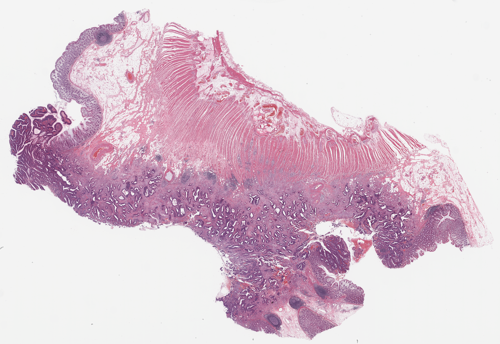

In [40]:
template_slide = open_slide(str(TEMPLATE_SLIDE_PATH))
template_img = read_slide_at_mag(template_slide, ALIGNMENT_MAG).convert('RGB')

thumbnail(template_img, (500,500))

In [41]:
# Fit normaliser to template image
normaliser = IterativeNormaliser(NORMALISER_METHOD, STANDARDISE_LUMINOSITY)
normaliser.fit_target(template_img)

In [51]:
#slides
TP53_slides = [slide for slide in slides if 'TP53' in slide]
HE_slides = [slide for slide in slides if 'HandE' in slide]
Paired_slides = list(zip(TP53_slides, HE_slides))
print('Found {0} pairs of slides'.format(len(Paired_slides)))
for i, pair in enumerate(Paired_slides):
    tp53, he = pair
    verbose_print('{0}. {1}|{2}'.format(i + 1, tp53, he))

Found 17 pairs of slides
1. 1792_T_9500_2_TP53.svs|1792_T_9500_3_HandE.svs
2. 1798_T_9514_2_TP53.svs|1798_T_9514_3_HandE.svs
3. 1919_T_10779_2_TP53.svs|1919_T_10779_3_HandE.svs
4. 1932_T_9876_2_TP53.svs|1932_T_9876_3_HandE.svs
5. 1939_T_9661_2_TP53.svs|1939_T_9661_3_HandE.svs
6. 2011_T_9699_2_TP53.svs|2011_T_9699_3_HandE.svs
7. 2019_T_9717_2_TP53.svs|2019_T_9717_3_HandE.svs
8. 2023_T_9727_2_TP53.svs|2023_T_9727_3_HandE.svs
9. 2036_T_9729_2_TP53.svs|2036_T_9729_3_HandE.svs
10. 2038_T_11986_2_TP53.svs|2038_T_11986_3_HandE.svs
11. 2075_T_9787_2_TP53.svs|2075_T_9787_3_HandE.svs
12. 2090_T_10594_2_TP53.svs|2090_T_10594_3_HandE.svs
13. 232_T_13230_2_TP53.svs|232_T_13230_3_HandE.svs
14. 2382_T_15360_2_TP53.svs|2382_T_15360_3_HandE.svs
15. 526_T_15907_2_TP53.svs|526_T_15907_3_HandE.svs
16. 526_T_15915_2_TP53.svs|526_T_15915_3_HandE.svs
17. 526_T_15923_2_TP53.svs|526_T_15923_3_HandE.svs


In [52]:
SLIDE_NUM = 3
PREFIX = Paired_slides[SLIDE_NUM][0][:-8]
verbose_print('Processing Slide: {0}'.format(PREFIX))
tp53_name, he_name = Paired_slides[SLIDE_NUM]
tp53_slide = open_slide(str(SLIDES_PATH.joinpath(tp53_name)))
he_slide = open_slide(str(SLIDES_PATH.joinpath(he_name)))

Processing Slide: 1932_T_9876_2_


In [53]:
#Load Slides
he = read_slide_at_mag(he_slide, ALIGNMENT_MAG).convert('RGB')
tp53 = read_slide_at_mag(tp53_slide, ALIGNMENT_MAG).convert('RGB')

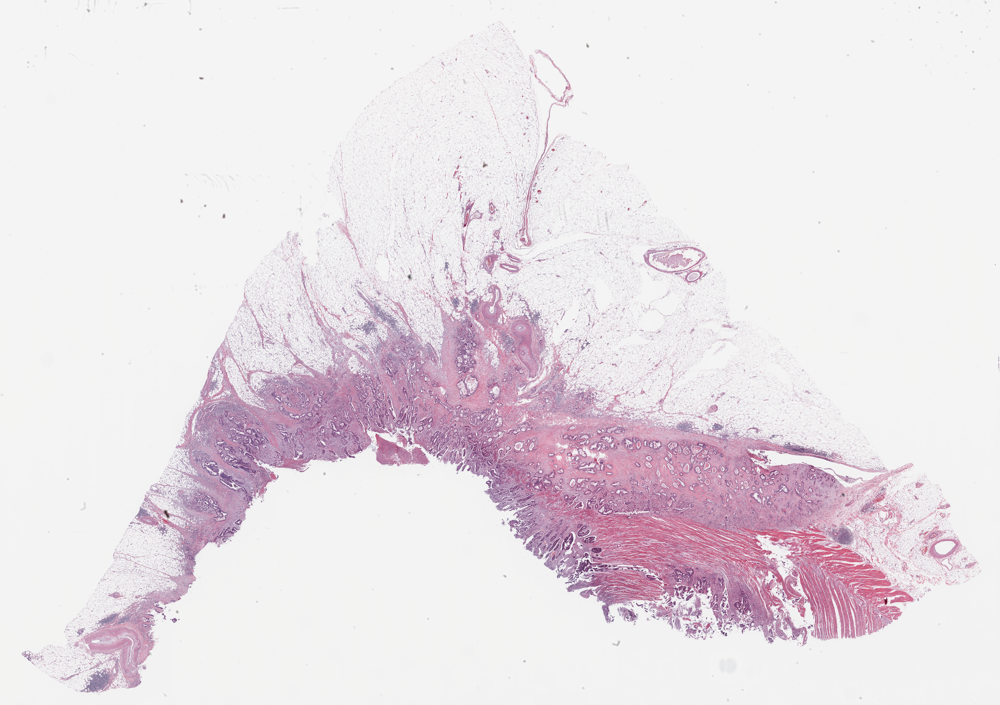

In [54]:
thumbnail(he)

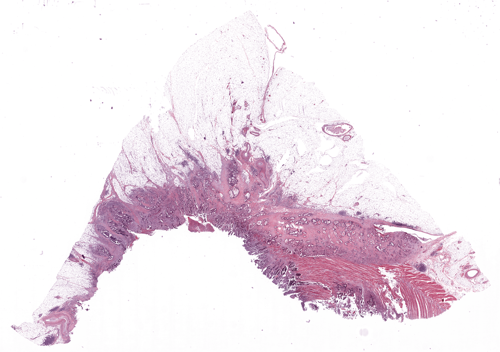

In [55]:
#Normalise H&E slide against the template slide 
normaliser.fit_source(he)
he_norm = normaliser.transform_tile(he)

thumbnail(he_norm, (500,500))

## TP53 Masking

In [25]:
#Load Slides
he = read_slide_at_mag(he_slide, ALIGNMENT_MAG).convert('RGB')
tp53 = read_slide_at_mag(tp53_slide, ALIGNMENT_MAG).convert('RGB')

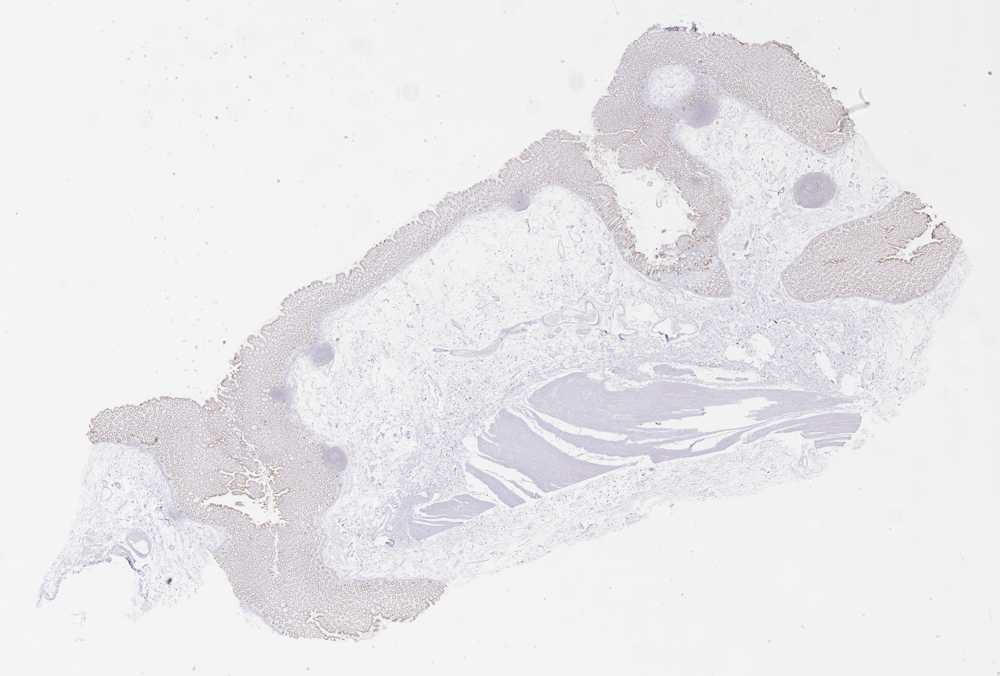

In [8]:
thumbnail(tp53)

<IPython.core.display.Javascript object>


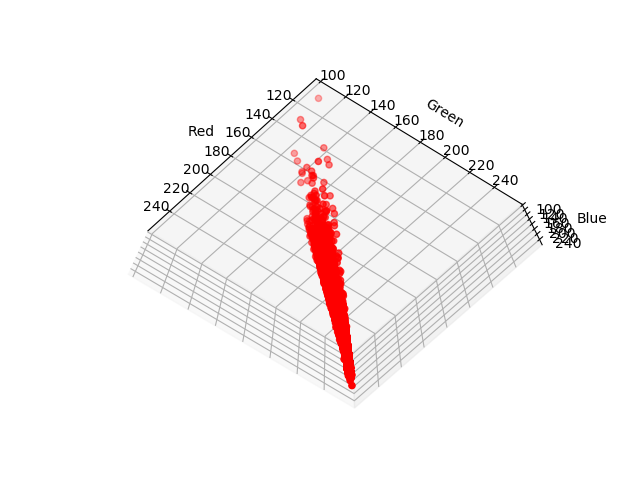

Text(0.5, 0, 'Blue')

In [9]:
# fig = plt.figure()
# axis = fig.add_subplot(1, 1, 1, projection='3d')

# tp53_small = thumbnail(tp53, (500,500))
# r, g, b = list(tp53_small.getdata(0)), list(tp53_small.getdata(1)), list(tp53_small.getdata(2))

# axis.scatter(r, g, b, c="#ff0000", marker="o")
# axis.set_xlabel("Red")
# axis.set_ylabel("Green")
# axis.set_zlabel("Blue")

### Grabcut

In [10]:
tp53_cv = np.array(thumbnail(tp53))[:, :, ::-1]   #Convert RGB to BGR

In [11]:
def imshow(img_cv):
    """Display OpenCV images with Pillow
    
    Parameters
    ----------
    img_cv : OpenCV image
    
    Returns
    -------
    img_pil : Pillow(rgb) image
    """
    #Convert grayscale image
    if len(img_cv.shape) == 2:
        return Image.fromarray(img_cv, 'L')
    #Convert BGR image
    elif img_cv.shape[2] == 3:
        img_rgb = img_cv[:, :, ::-1]    #Convert from BGR to RGB
        return Image.fromarray(img_rgb)

In [12]:
mask = np.zeros(tp53_cv.shape[:2], np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

In [13]:
tp53_cv.shape

(676, 1000, 3)

In [16]:
# Format x,y,w,h
rect = (10,10, 970, 640)

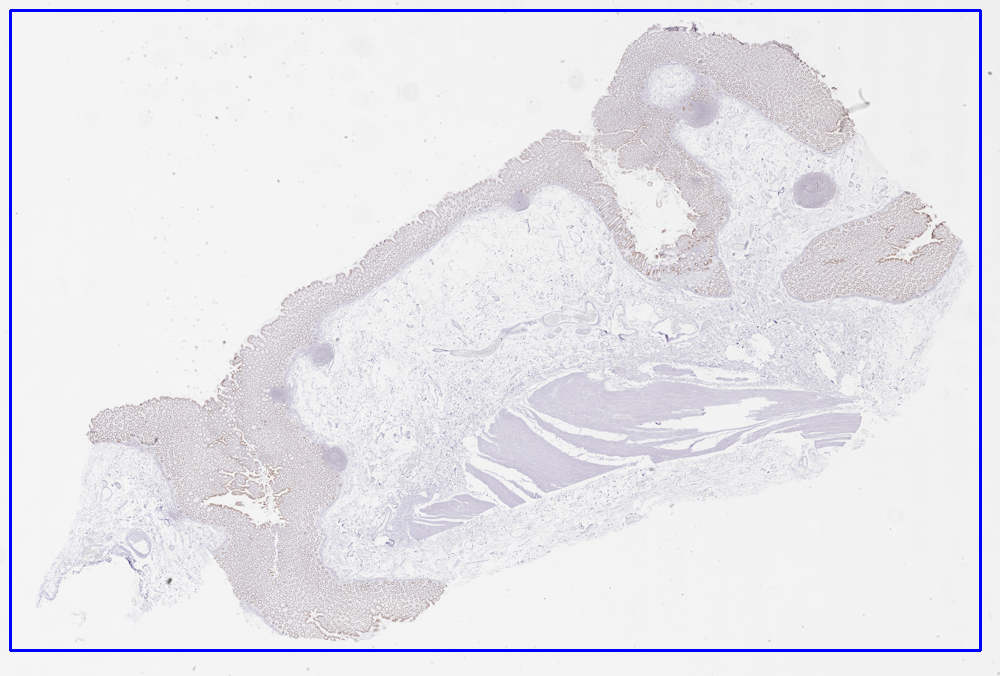

In [17]:
tp53_box = tp53_cv.copy()
tp53_box = cv.rectangle(tp53_box, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (255,0,0), 2)
thumbnail(imshow(tp53_box))

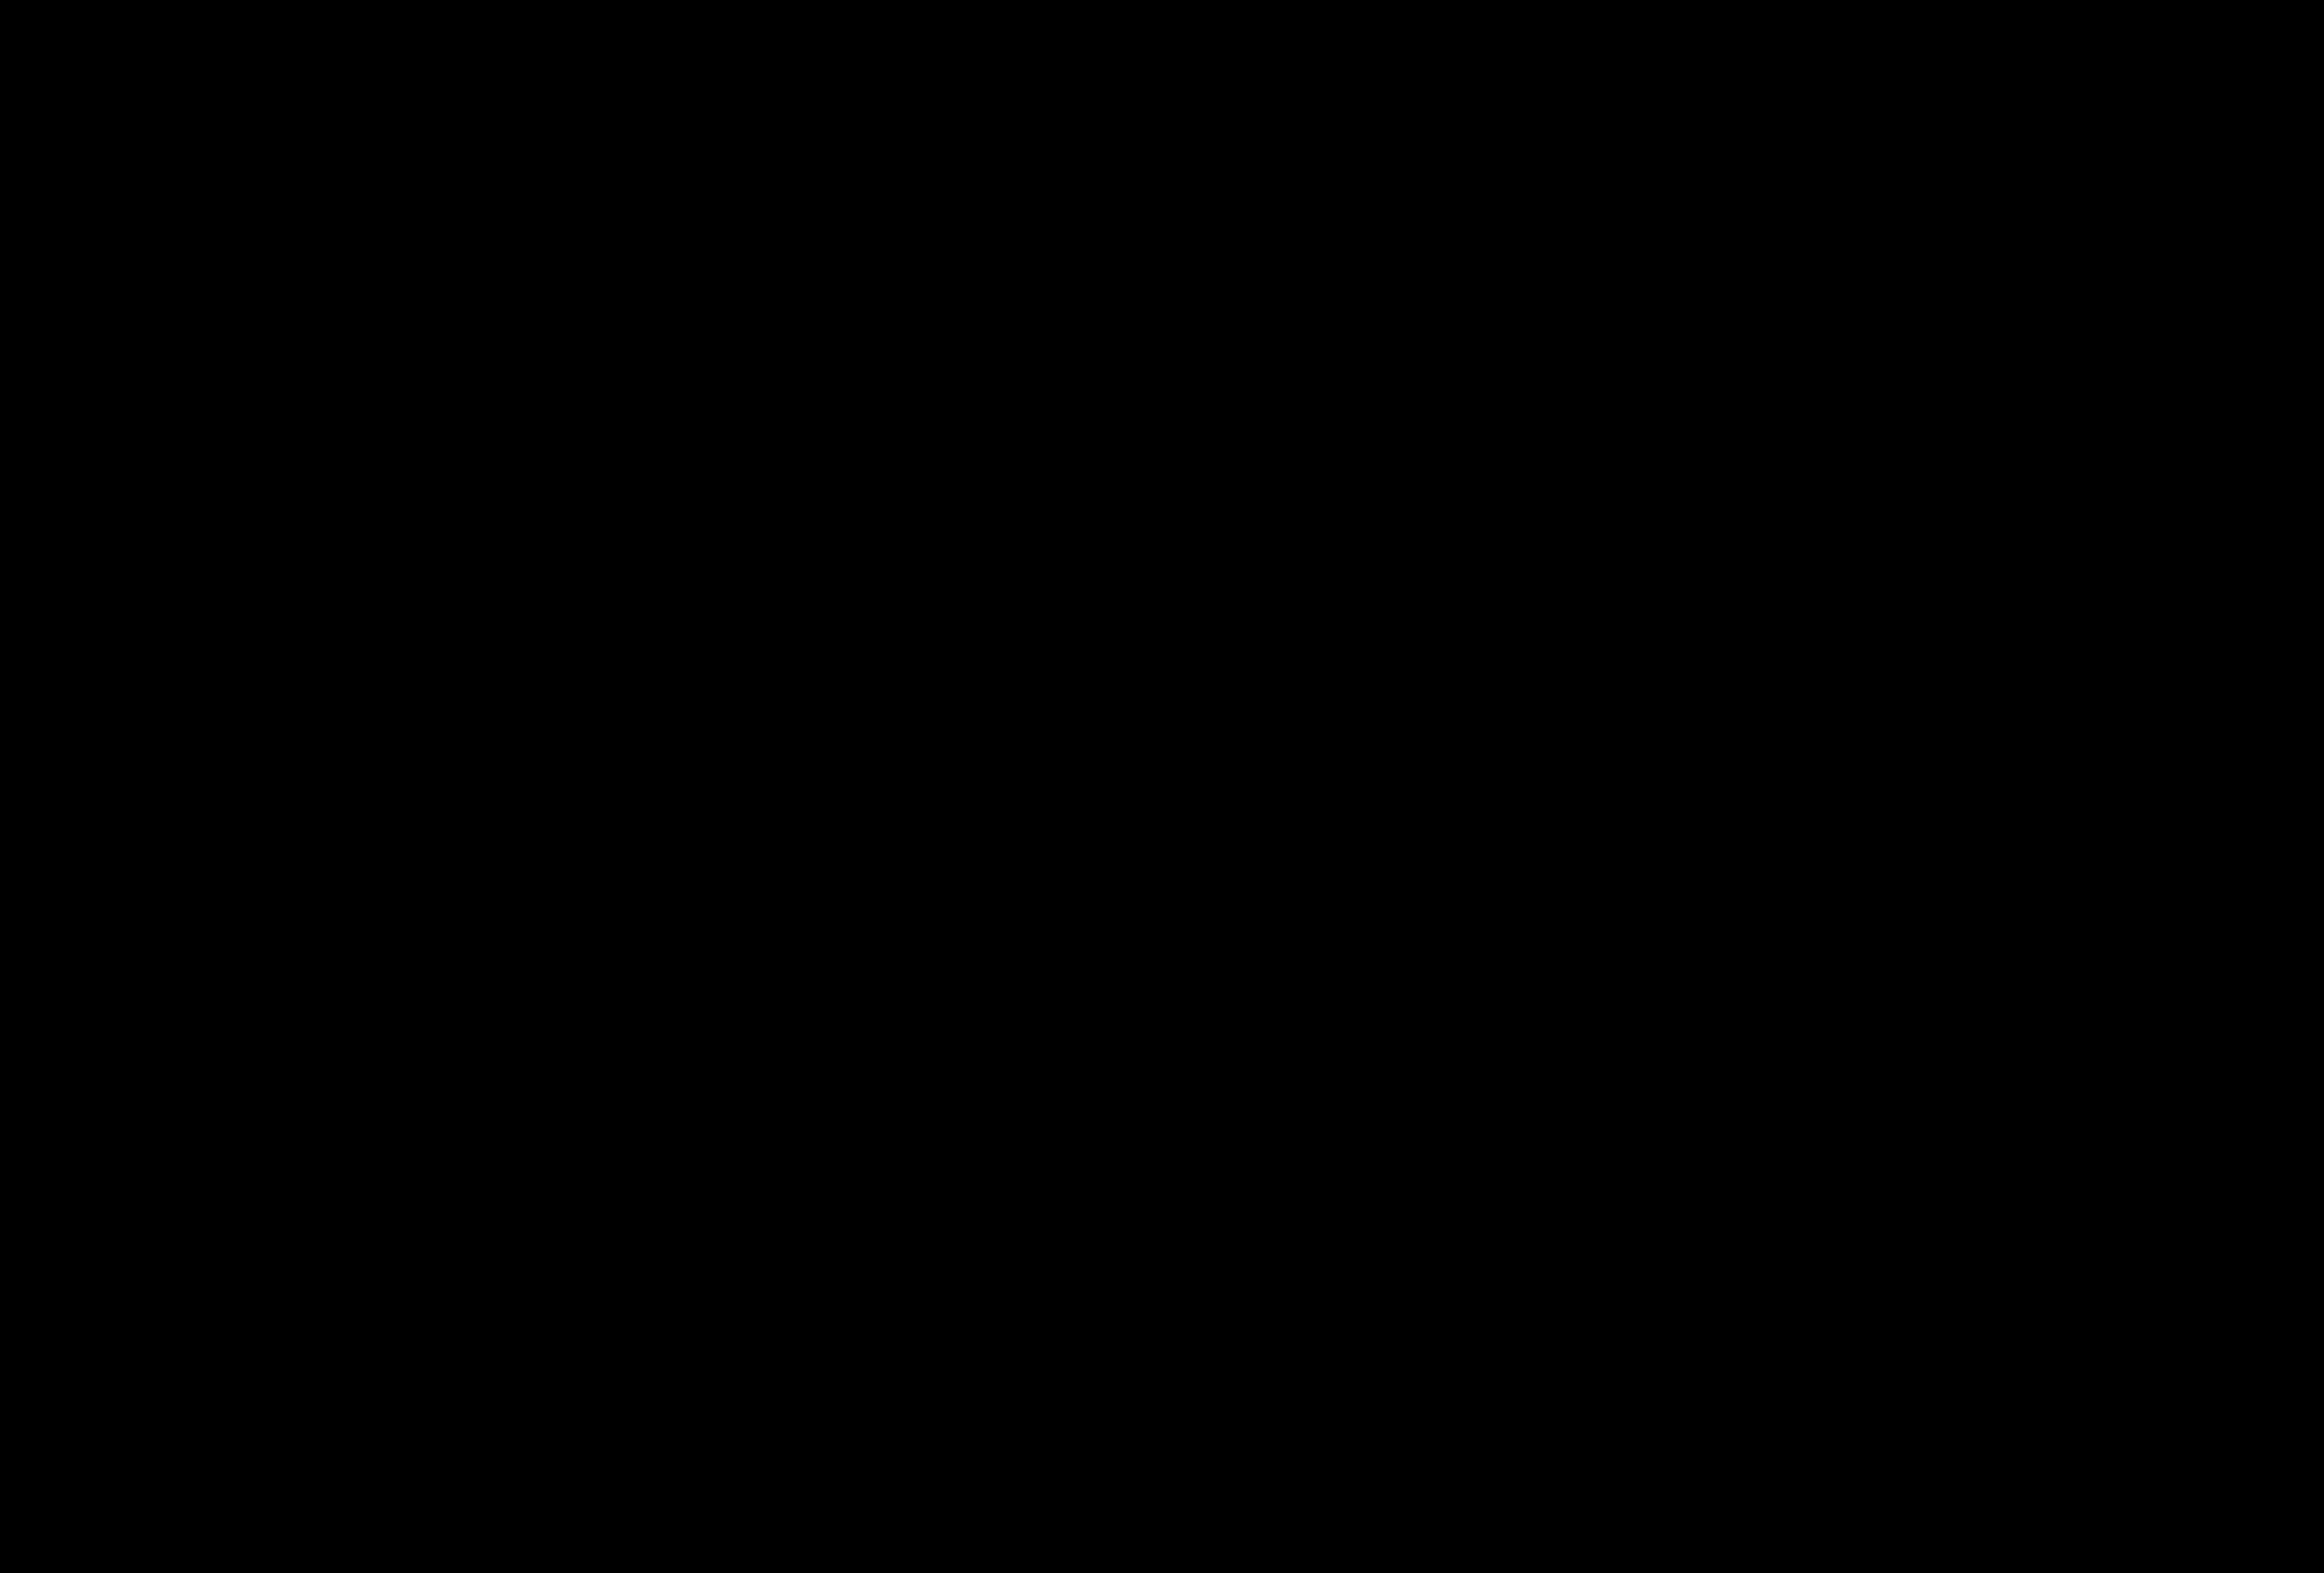

In [15]:
imshow(mask)

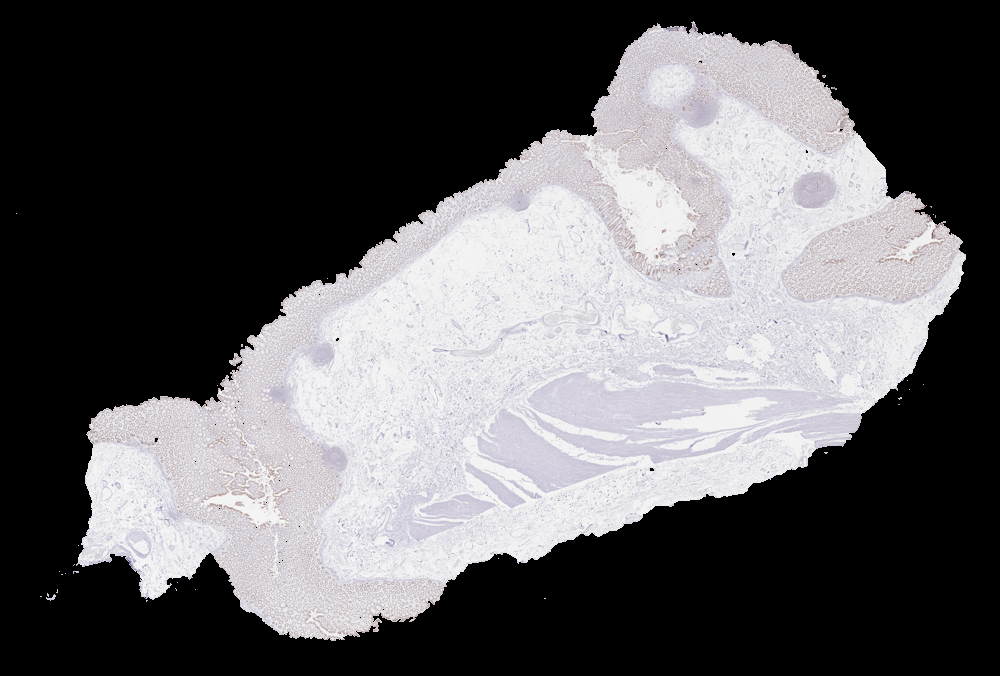

In [19]:
tp53_cut = tp53_cv.copy()
cv.grabCut(tp53_cut,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
tp53_cut = tp53_cut*mask2[:,:,np.newaxis]

imshow(tp53_cut)

In [14]:
tp53_gray = tp53.convert('L')

tp53_gray

## H&E Masking

In [69]:
he_filtered = filter_green(he_norm)
he_filtered = filter_grays(he_norm, tolerance = 15)

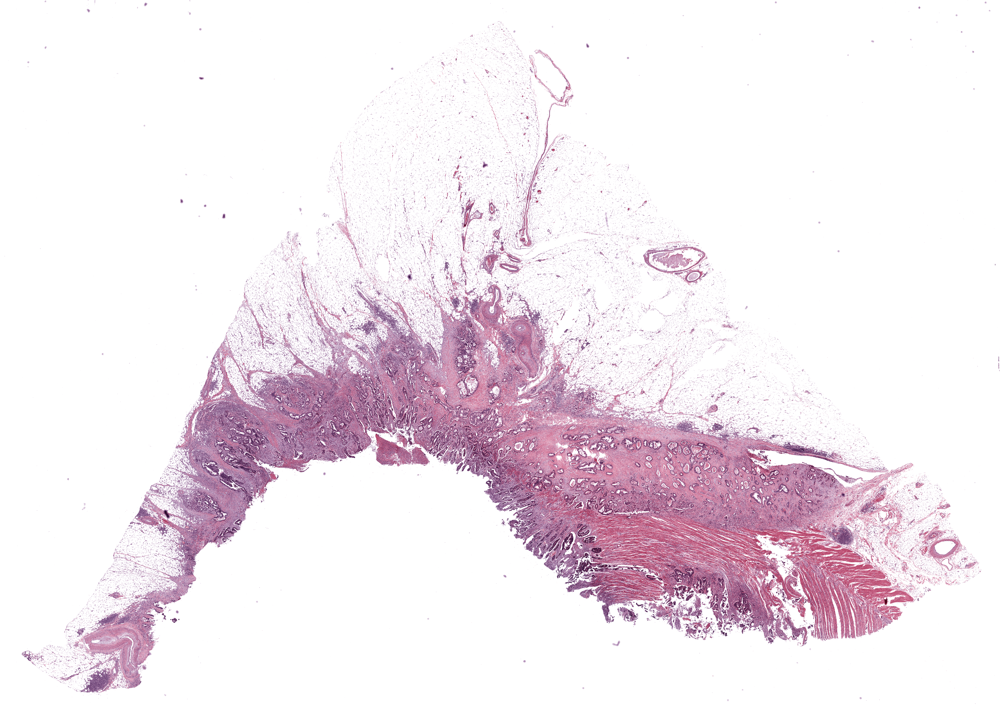

In [70]:
thumbnail(he_filtered)

In [77]:
he_mask = he_filtered.convert('L')

In [89]:
np.array(he_mask) == 255

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

<IPython.core.display.Javascript object>


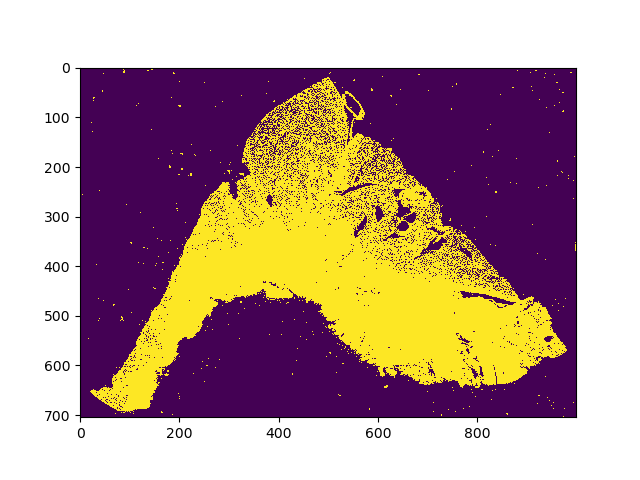

In [96]:
plt.imshow(np.array(he_mask) == 255)

In [72]:
he_cv = np.array(thumbnail(he_filtered))[:, :, ::-1]   #Convert RGB to BGR

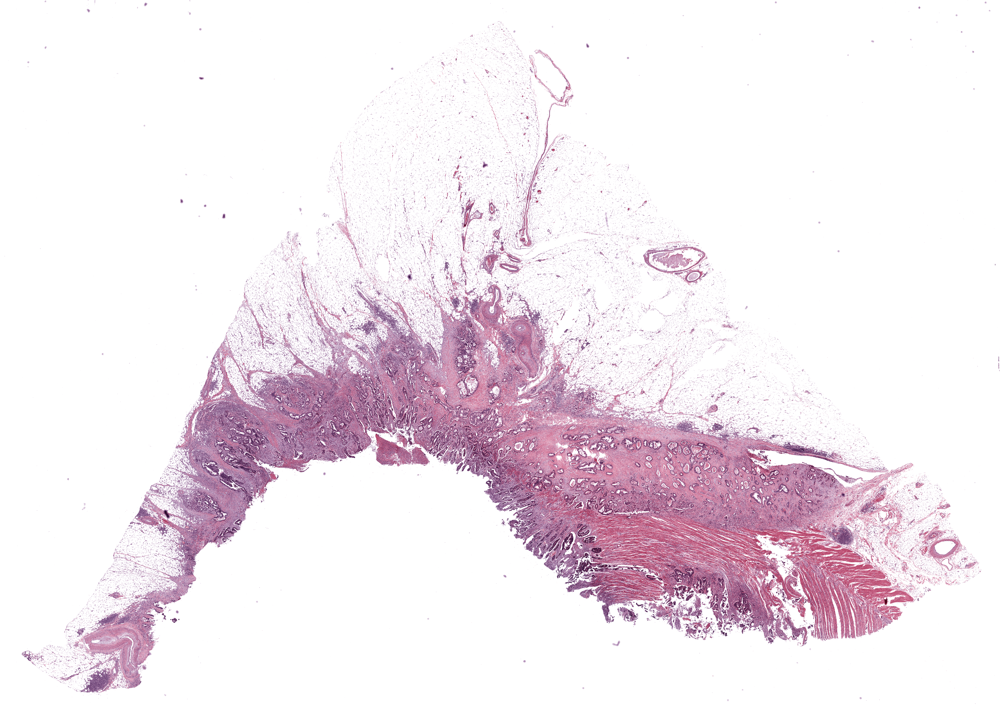

In [101]:
imshow(he_cv)

In [103]:
mask = (np.array(thumbnail(he_mask)) != 255).astype(np.uint8)
#mask = np.zeros(he_cv.shape[:2], np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

In [104]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [74]:
he_cv.shape

(705, 1000, 3)

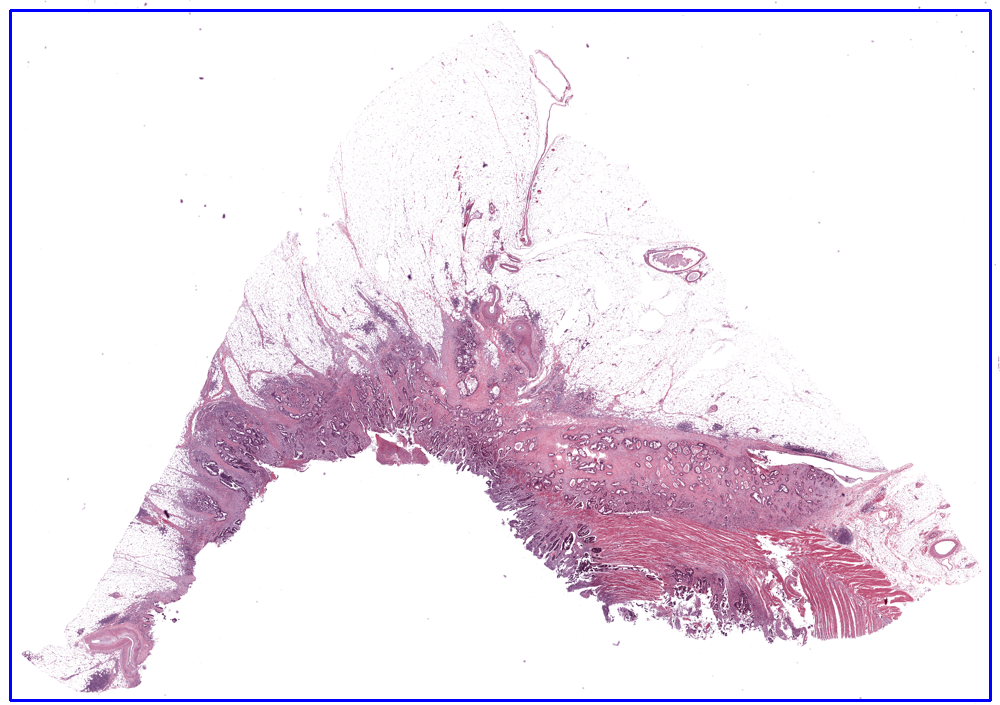

In [75]:
# Format x,y,w,h
rect = (10,10, 980, 690)

he_box = he_cv.copy()
he_box = cv.rectangle(he_box, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (255,0,0), 2)
thumbnail(imshow(he_box))

In [97]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [110]:
he_cut = he_cv.copy()
#cv.grabCut(he_cut,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)
cv.grabCut(he_cut,mask,None,bgdModel,fgdModel,5,cv.GC_INIT_WITH_MASK)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')

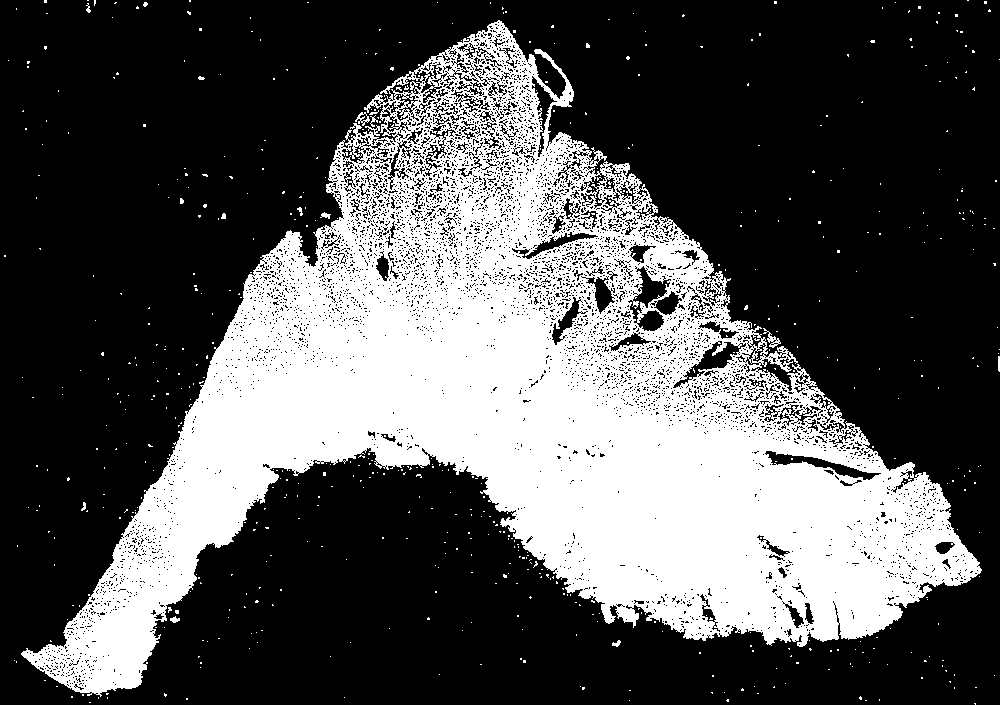

In [117]:
imshow(mask2*255)

In [119]:
mask2

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [140]:
mask2

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [144]:
mask2_remove = remove_small_objects(mask2, 100)

imshow(mask2_remove*255)

he_cut = he_cut*mask2[:,:,np.newaxis]

imshow(he_cut)

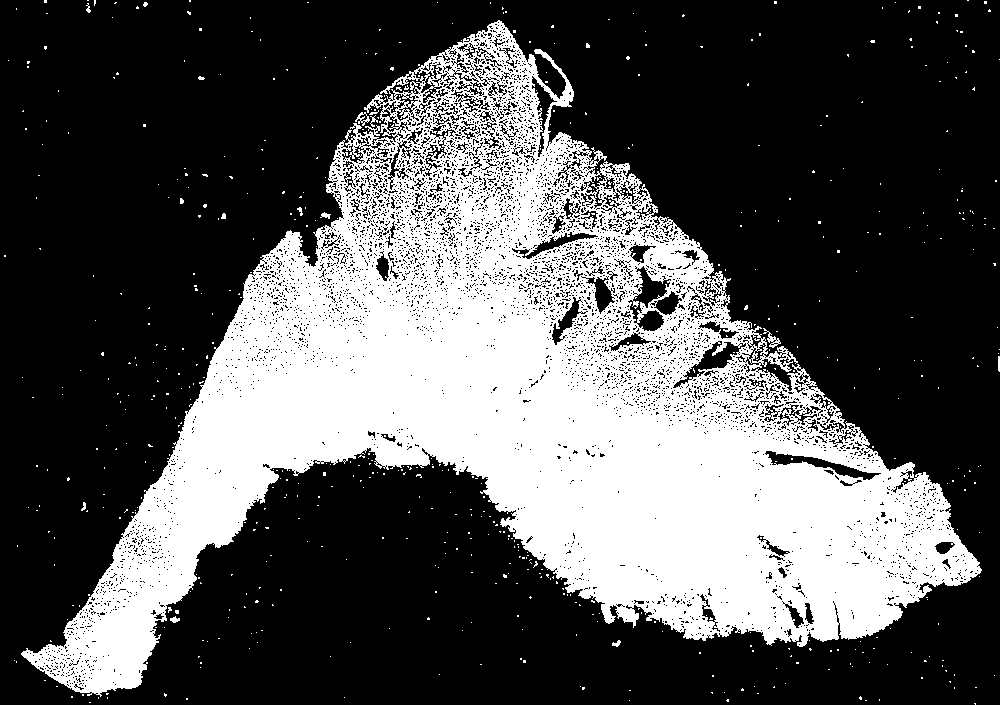

In [145]:
imshow(mask2_remove*255)

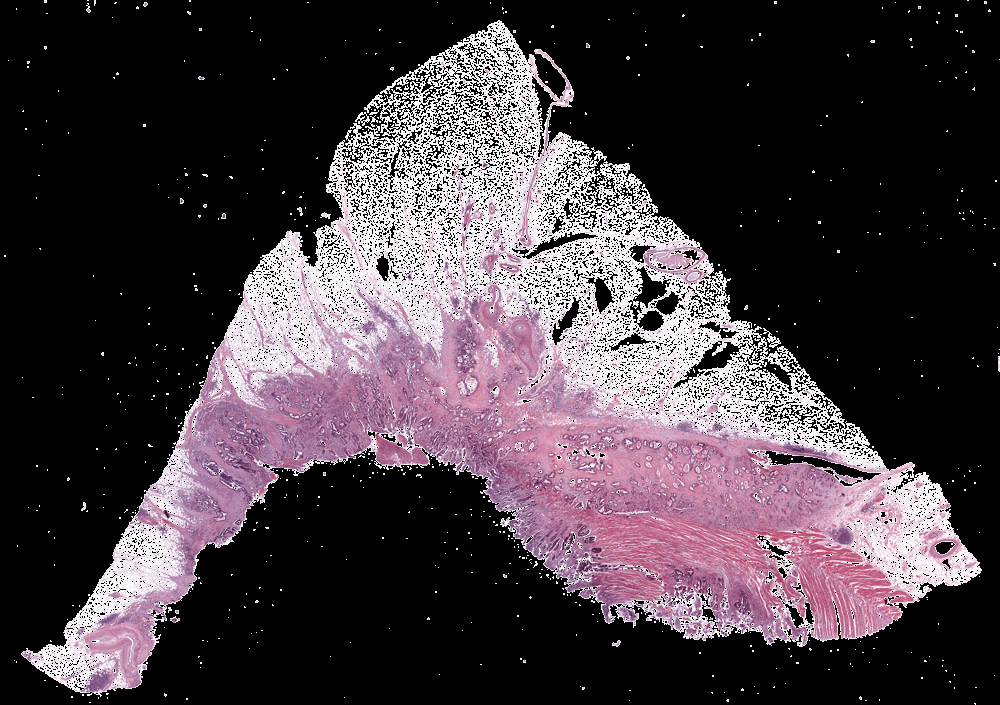

In [112]:
he_cut = he_cut*mask2[:,:,np.newaxis]

imshow(he_cut)

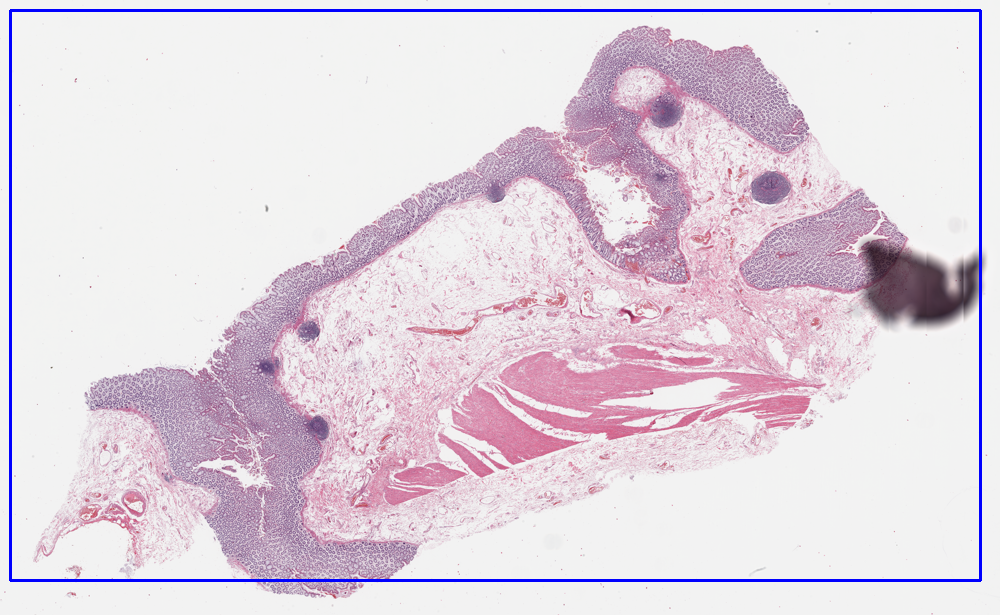

In [34]:
he_box = he_cv.copy()
he_box = cv.rectangle(he_box, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (255,0,0), 2)
thumbnail(imshow(he_box))